# JUSTIFICATION

With this project we are going to find out if we can predict the sales of a company through the time with Recurrent Neural Network which is a kind of Neura Networks that works better with series data set such us dates and numbers.

# IMPORTING LIBRARIES AND VISUALIZING THE DATA SET

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("RSCCASN.csv", parse_dates = True, index_col="DATE")
data.columns = ["Sales"]
data

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


A plot of the sale by years.

<AxesSubplot:xlabel='DATE'>

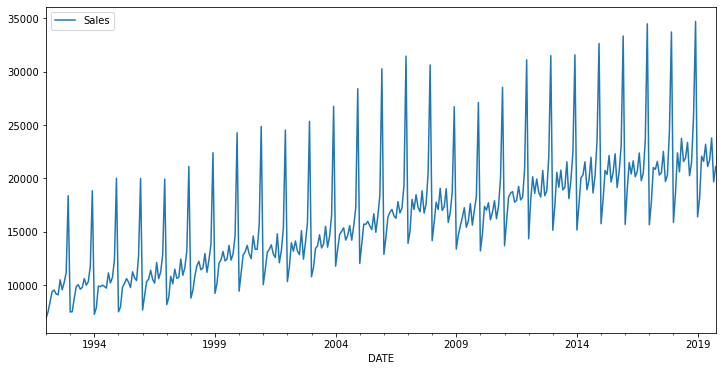

In [3]:
data.plot(figsize=(12,6))

# SEPARATING THE DATASET INTO TRAIN AND TEST

In [4]:
len(data)

334

In [5]:
test_size = 18
test_ind = len(data)-test_size

In [6]:
train = data.iloc[:test_ind]
test = data.iloc[test_ind:]

In [7]:
print(len(train))
print(len(test))

316
18


# PRE PROCESSING

First we are going to make lower the numbers because it is better for the machine in terms of efficiency. But this will not change the distance between those.

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
scaler.fit(train)

MinMaxScaler()

In [11]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Now we are going to use the TimeseriesGenerator, which is a powerful tool that can help you to preprocess and prepare your time series data for machine learning, while also improving the efficiency and performance of your models.

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size=1)

In [14]:
X,y = generator[0]

In [15]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

# BUILDING THE DEEP LEARNING MODEL

With one layer of the LSTM, which stands for Long Short-Term Memory, which is a type of recurrent neural network (RNN) that is designed to capture long-term dependencies in sequential data.

And the optimizer of Adam and as a loss metric the MSE(Mean Squared Error):

Adam is an optimization algorithm that is commonly used in deep learning. It is an adaptive learning rate method that combines the benefits of both Adagrad and RMSProp algorithms. By using adaptive learning rates for each parameter, Adam is able to converge faster and has been shown to perform well on a wide range of deep learning problems.

Mean Squared Error (MSE) is a loss function that is commonly used in regression problems. It measures the average squared difference between the predicted and actual values. The goal of training a neural network with MSE loss is to minimize the difference between the predicted and actual values.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [17]:
n_features = 1

In [18]:
model = Sequential()
model.add(LSTM(100, activation = "relu", input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer="adam", loss = "mse")

Adding the Early Stopping to break the training of the model to avoid the overfitting.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor="val_loss", patience = 2)

In [21]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

# TRAINING THE MODEL

In [22]:
model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks=[early_stop])

Epoch 1/20


C:\Users\ulise\AppData\Local\Temp/ipykernel_8900/998452603.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 20, validation_data = validation_generator, callbacks=[early_stop])


304/304 [==============================] - 2s 4ms/step - loss: 0.0274 - val_loss: 0.0394
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0143 - val_loss: 0.0103
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0034 - val_loss: 5.7288e-04
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 2.1021e-04
Epoch 7/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 8/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0024


The plot of the metrics.

<AxesSubplot:>

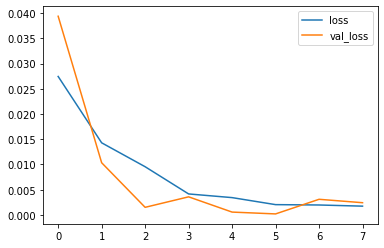

In [23]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# MAKING PREDICTIONS

We need a for cicle to get predictions on every batch on every value.

In [24]:
test_pre = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_pre.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 18ms/step


In [25]:
true_predictions = scaler.inverse_transform(test_pre)

In [26]:
test["Predictions"] = true_predictions

C:\Users\ulise\AppData\Local\Temp/ipykernel_8900/3424149773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_predictions


We add the predictions aside of the true value. At first, we can say that the values are pretty sure.

In [27]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22588.751772
2018-06-01,21589,21441.898867
2018-07-01,21919,21646.589015
2018-08-01,23381,23476.996165
2018-09-01,20260,20903.692063
2018-10-01,21473,21509.279584
2018-11-01,25831,25601.099317
2018-12-01,34706,36548.287271
2019-01-01,16410,17472.033274


With a plot we can easyly confirm that.

<AxesSubplot:xlabel='DATE'>

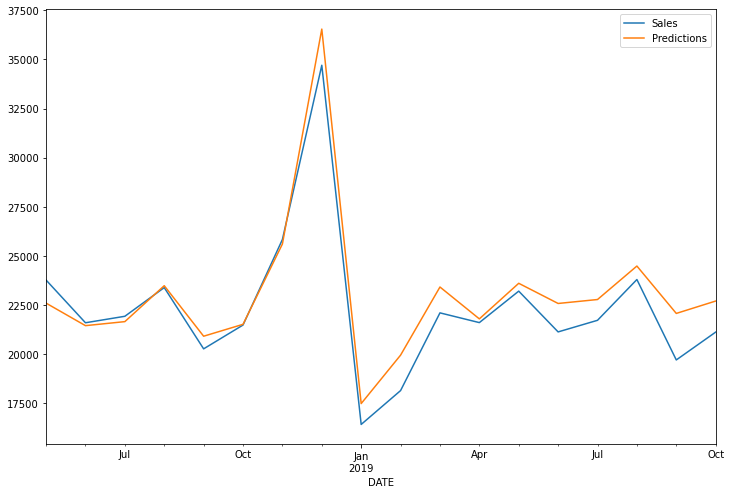

In [28]:
test.plot(figsize=(12,8))

# NOW LET'S FORECASTING

We make the same process but this one is a little bit less strict. Otherwise we are going to get the same results which is has no sense because we dont know the future so we would like to know an average.

In [29]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(data)

In [30]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size =1)

In [32]:
model = Sequential()

model.add(LSTM(100, activation = "relu", input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = "mse")

model.fit_generator(generator, epochs=8)


Epoch 1/8


C:\Users\ulise\AppData\Local\Temp/ipykernel_8900/361607079.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=8)


322/322 [==============================] - 3s 5ms/step - loss: 0.0231
Epoch 2/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0160
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 4/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0025
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0029
Epoch 6/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 7/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 8/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0013


# MAKING THE FUTURE PREDICTIONS

In [33]:
forecast = []
periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 22ms/step


In [34]:
forecast = scaler.inverse_transform(forecast)

In [37]:
data

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


Adding the dates  in the future.

In [39]:
forecast_index = pd.date_range(start="2019-11-01", periods = periods, freq = "MS")

In [40]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [41]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ["Forecast"])

The first plot is the original data and the second is the segment of time that we can forecast the sales.

<AxesSubplot:>

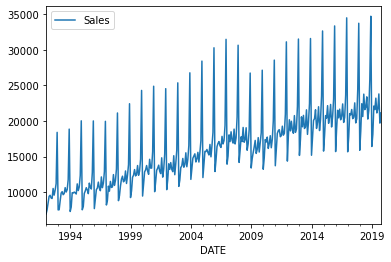

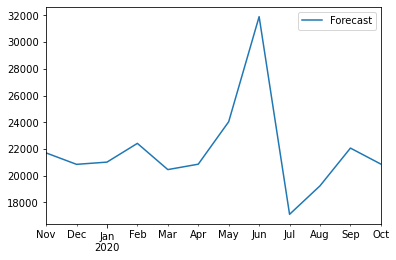

In [42]:
data.plot()
forecast_df.plot()

# RESULTS

We may have those sales in the future according to our data. We cannot make a report of the efficiency of the model because we have to wait till those dates to check if the DL model is correct.

(576.0, 611.0)

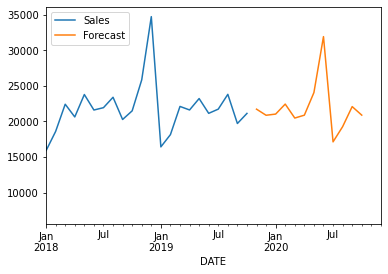

In [46]:
ax = data.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01", "2020-12-01")